In [0]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import csv
import numpy as np


In [2]:

url = "https://raw.githubusercontent.com/ageron/handson-ml/master/datasets/housing/housing.csv"

dataset = pd.read_csv(url)
dataset = dataset.dropna()

print("first five rows:")
dataset.head(10)




first five rows:


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY
5,-122.25,37.85,52.0,919.0,213.0,413.0,193.0,4.0368,269700.0,NEAR BAY
6,-122.25,37.84,52.0,2535.0,489.0,1094.0,514.0,3.6591,299200.0,NEAR BAY
7,-122.25,37.84,52.0,3104.0,687.0,1157.0,647.0,3.1200,241400.0,NEAR BAY
8,-122.26,37.84,42.0,2555.0,665.0,1206.0,595.0,2.0804,226700.0,NEAR BAY
9,-122.25,37.84,52.0,3549.0,707.0,1551.0,714.0,3.6912,261100.0,NEAR BAY


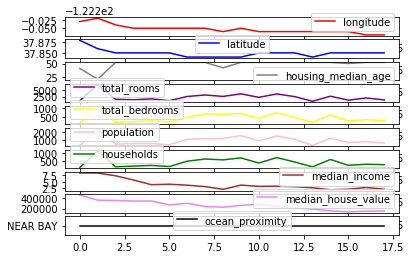

In [3]:
ax_list = [] # used to store the object of the subplot
lst = [i for i in range(18)] 
color_list = ["red","blue","grey","purple","yellow","pink","green","brown","violet","black"]
fig, ax = plt.subplots(10)
for i in range(10):
  ax_list.append(ax[i])
feature_list = []
for i in dataset:
  feature_list.append(str(i))
for i in range(len(ax_list)):
  ax_list[i].plot(lst,dataset[feature_list[i]][0:18],color_list[i])
  ax_list[i].legend([feature_list[i]])

In [0]:
Y = dataset['median_house_value']

X = dataset.loc[:,'longitude':'median_income']

In [5]:
X.shape

(20433, 8)

In [6]:
Y.shape

(20433,)

In [0]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size= 0.3)

x_train_np = x_train.to_numpy()
y_train_np = y_train.to_numpy()

x_test_np = x_test.to_numpy()
y_test_np = y_test.to_numpy()


# print("There are " + str(x_train.size) + " training entries and "+  str(x_test.size) + " testing entries ")

In [0]:
import torch

from torch.nn import Conv1d

from torch.nn import MaxPool1d

from torch.nn import Flatten

from torch.nn import Linear

from torch.nn.functional import relu

from torch.utils.data import DataLoader, TensorDataset

In [0]:
class CnnRegressor(torch.nn.Module):
  def __init__(self, batch_size, inputs, outputs):
    super(CnnRegressor, self).__init__()
    self.batch_size = batch_size
    self.inputs = inputs
    self.outputs = outputs

    self.input_layer = Conv1d(inputs, batch_size, 1)

    self.max_pooling_layer = MaxPool1d(1)

    self.conv_layer = Conv1d(batch_size, 128, 1)
    # self.max_pooling_layer1 = MaxPool1d(1)
    # self.conv_layer1 = Conv1d(128,128,1)

    self.flatten_layer = Flatten()

    self.linear_layer = Linear(128, 128)

    self.output_layer = Linear(128, outputs)

  def feed(self, input):
    input = input.reshape((self.batch_size, self.inputs,1))
    output = relu(self.input_layer(input))

    output = self.max_pooling_layer(output)

    output = relu(self.conv_layer(output))
    # output = self.max_pooling_layer1(output)
    # output = relu(self.conv_layer1(output))
    output = self.flatten_layer(output)

    output = self.linear_layer(output)

    output = self.output_layer(output)
    return output


In [10]:
from torch.optim import Adam

from torch.nn import L1Loss

!pip install pytorch-ignite

from ignite.contrib.metrics.regression.r2_score import R2Score

     |████████████████████████████████| 112kB 10.9MB/s 


In [11]:
batch_size = 64
model = CnnRegressor(batch_size, X.shape[1], 1)
model.cuda()

CnnRegressor(
  (input_layer): Conv1d(8, 64, kernel_size=(1,), stride=(1,))
  (max_pooling_layer): MaxPool1d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
  (conv_layer): Conv1d(64, 128, kernel_size=(1,), stride=(1,))
  (flatten_layer): Flatten()
  (linear_layer): Linear(in_features=128, out_features=128, bias=True)
  (output_layer): Linear(in_features=128, out_features=1, bias=True)
)

In [0]:
def model_loss(model, dataset, train = False, optimizer = None):
  performance = L1Loss()
  score_metric = R2Score()

  avg_loss = 0
  avg_score = 0
  count = 0

  for input, output in iter(dataset):
    predections = model.feed(input)

    loss = performance(predections, output)

    score_metric.update([predections, output])
    score = score_metric.compute()

    if(train):
      optimizer.zero_grad()

      loss.backward()

      optimizer.step()
    
    avg_loss += loss.item()

    avg_score += score
    count += 1

  return avg_loss / count, avg_score / count


In [13]:
import time
epochs = 1000

optimizer = Adam(model.parameters())

inputs = torch.from_numpy(x_train_np).cuda().float()
outputs = torch.from_numpy(y_train_np.reshape(y_train_np.shape[0],1)).cuda().float()
tensor = TensorDataset(inputs, outputs)

loader = DataLoader(tensor,batch_size, shuffle=True, drop_last=True)
time_stamp1 = time.time()  # used to get the running time for the model
for epoch in range(epochs):
  avg_loss, avg_r2_score = model_loss(model, loader, train=True, optimizer=optimizer)

  print("Epoch " + str(epoch + 1) + ":\n\tLoss = " + str(avg_loss) + "\n\tR^2 Score = " + str(avg_r2_score))
time_stamp2 = time.time() # used to get the running time for the model

Epoch 1:
	Loss = 131075.28608464127
	R^2 Score = -2.0792780154638377
Epoch 2:
	Loss = 88038.87100616592
	R^2 Score = -0.3253014245643394
Epoch 3:
	Loss = 80883.09753363229
	R^2 Score = 0.14684144949791
Epoch 4:
	Loss = 78540.47575672646
	R^2 Score = 0.21070985292145678
Epoch 5:
	Loss = 76705.18800798767
	R^2 Score = 0.26176714316553157
Epoch 6:
	Loss = 74330.91231081838
	R^2 Score = 0.29205747698839907
Epoch 7:
	Loss = 72519.30395179373
	R^2 Score = 0.31883817578775914
Epoch 8:
	Loss = 70532.74961463004
	R^2 Score = 0.34965643449145783
Epoch 9:
	Loss = 70540.32050518498
	R^2 Score = 0.3499367400351255
Epoch 10:
	Loss = 67812.8558015695
	R^2 Score = 0.3751873121779879
Epoch 11:
	Loss = 66780.81300798767
	R^2 Score = 0.41510705968798867
Epoch 12:
	Loss = 65422.0323360426
	R^2 Score = 0.4123933526950826
Epoch 13:
	Loss = 64442.72188551009
	R^2 Score = 0.44019634525022294
Epoch 14:
	Loss = 62791.394688901346
	R^2 Score = 0.4714890790333316
Epoch 15:
	Loss = 61664.77867502803
	R^2 Score = 0

In [16]:
print(f"Time taken for training the model: {time_stamp2-time_stamp1} second")
filepath = "/content/sample_data/kevin.pth"
torch.save(model,filepath)
model = torch.load(filepath)

Time taken for training the model: 664.6417133808136 second


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type CnnRegressor. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [17]:

inputs = torch.from_numpy(x_test_np).cuda().float()
outputs = torch.from_numpy(y_test_np.reshape(y_test_np.shape[0],1)).cuda().float()

tensor = TensorDataset(inputs, outputs)

loader = DataLoader(tensor,batch_size, shuffle=True, drop_last=True)

avg_loss, avg_r2_score = model_loss(model, loader)

print("Loss = " + str(avg_loss) + "\nR^2 Score = " + str(avg_r2_score))



Loss = 45119.118174342104
R^2 Score = 0.7047528305661513
